In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob as gb
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn

In [6]:
# Loading labels
dataset = "HAM10000_dataset/"
label_path = dataset + "GroundTruth.csv"
mask_dir = dataset+"masks/"
images_dir = dataset + "images/"
img_files = sorted([f for f in os.listdir(images_dir) if f.endswith(".jpg")])
mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith(".png")])

In [7]:
image_names = [os.path.splitext(f)[0] for f in img_files]    # ('ISIC_0024306', '.jpg')
mask_names = [os.path.splitext(f)[0].replace('_segmentation', '') for f in mask_files]    # ('ISIC_0024306_segmentation', 'png')

missing_masks = [f for f in image_names if f not in mask_names]

if len(missing_masks) == 0:
    print('No missing masks found.')
else:
    print(f"There are {len(missing_masks)} missing masks found:")
    print(missing_masks)

No missing masks found.


In [8]:
len(img_files), len(mask_files)

(10015, 10015)

In [9]:


def display_image_and_mask(n=5, seed=None):
    if seed:
        np.random.seed(seed)

    fig, axs = plt.subplots(2, n, figsize=(20, 6))
    for i in range(n):
        idx = np.random.randint(0, len(img_files))
        img_path = os.path.join(images_dir, img_files[idx])
        mask_path = os.path.join(mask_dir, os.path.splitext(img_files[idx])[0] + '_segmentation.png')    # mask_files[idx]

        img = Image.open(img_path)
        mask = Image.open(mask_path)

        axs[0, i].imshow(img)
        axs[0, i].set_title('Image')
        axs[0, i].axis('off')

        axs[1, i].imshow(mask)
        axs[1, i].set_title('Mask')
        axs[1, i].axis('off')

plt.show()

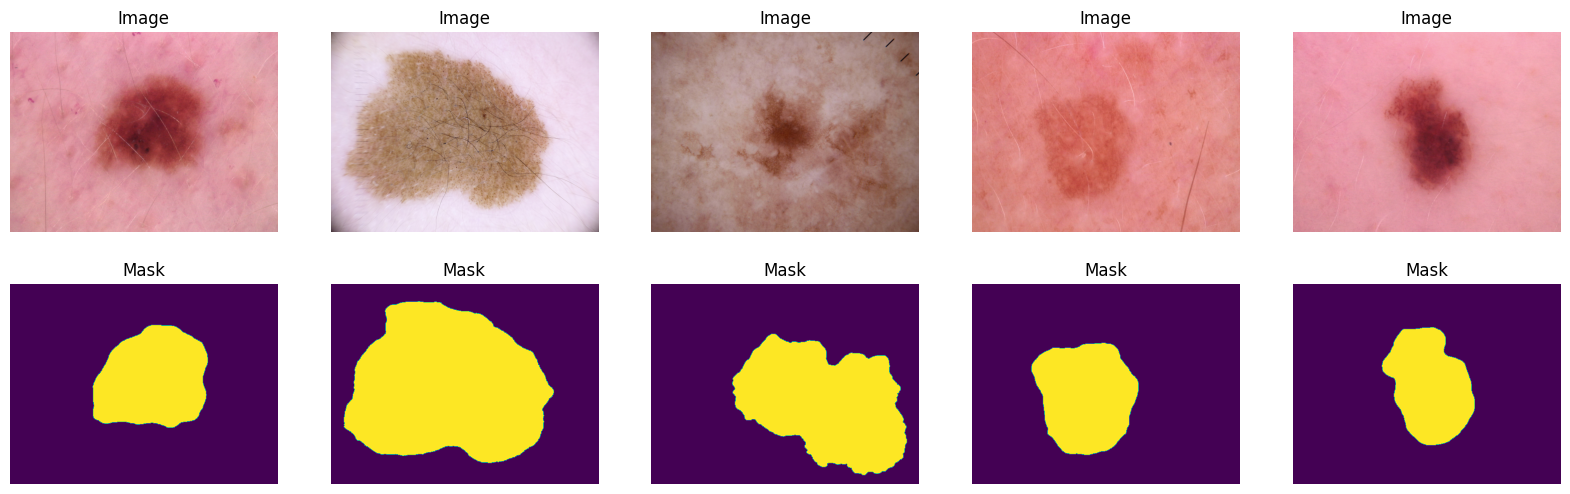

In [10]:
display_image_and_mask(n=5, seed=42)

In [11]:
def display_image_with_mask(n=5, seed=None):
    if seed:
        np.random.seed(seed)

    fig, axs = plt.subplots(1, n, figsize=(20, 5))
    for i in range(n):
        idx = np.random.randint(0, len(img_files))
        img_path = os.path.join(images_dir, img_files[idx])
        mask_path = os.path.join(mask_dir, os.path.splitext(img_files[idx])[0] + '_segmentation.png')    # mask_files[idx]

        img_np = np.array(Image.open(img_path))
        mask_np = np.array(Image.open(mask_path))

        axs[i].imshow(img_np)
        axs[i].imshow(mask_np, cmap='Reds', alpha=0.5)
        axs[i].set_title('Image with Mask')
        axs[i].axis('off')

plt.show()

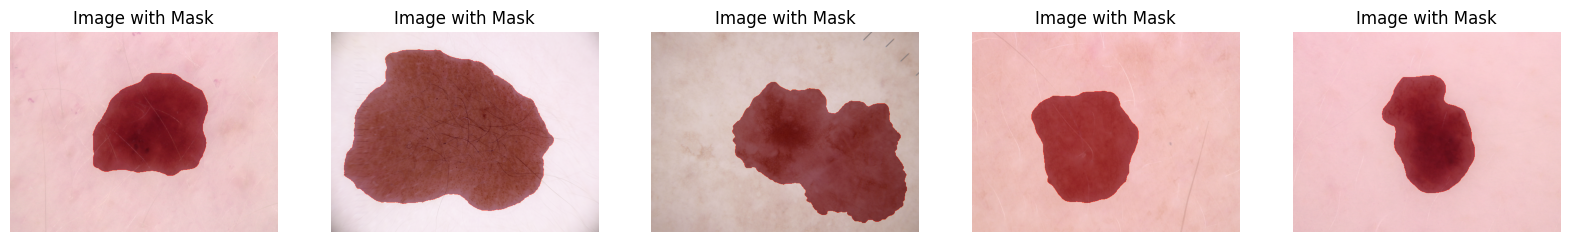

In [12]:
display_image_with_mask(n=5, seed=42)

In [13]:
def img_mask_paths(img_dir, mask_dir):
    img_path = sorted(gb.glob(os.path.join(img_dir, '*.jpg')))
    mask_path = sorted(gb.glob(os.path.join(mask_dir, '*.png')))
    return np.array(img_path), np.array(mask_path)

imgs_path, masks_path = img_mask_paths(images_dir, mask_dir)

In [14]:
# Load the dataset
dataset = "HAM10000_dataset/"
label_path = os.path.join(dataset, "GroundTruth.csv")
labels_df = pd.read_csv(label_path)

In [15]:
# Create a new column 'class' that contains the class label
labels_df['class'] = labels_df[['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].idxmax(axis=1)


In [16]:
# Split dataset
train_df, temp_df = train_test_split(labels_df, test_size=0.2, stratify=labels_df['class'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['class'])


In [17]:
# Function to save splits
def save_split(df, split_name):
    os.makedirs(split_name, exist_ok=True)
    for _, row in df.iterrows():
        shutil.copy(f'HAM10000_dataset/images/{row["image"]}.jpg', f'{split_name}/{row["image"]}.jpg')
        shutil.copy(f'HAM10000_dataset/masks/{row["image"]}_segmentation.png', f'{split_name}/{row["image"]}_mask.png')
# Save the splits
save_split(train_df, 'train')
save_split(val_df, 'val')
save_split(test_df, 'test')


In [18]:
print(f'Train: {len(train_df)} samples')
print(f'Validation: {len(val_df)} samples')
print(f'Test: {len(test_df)} samples')

Train: 8012 samples
Validation: 1001 samples
Test: 1002 samples


In [19]:

# Resize images and masks
resize_transform = transforms.Resize((128, 128))

def resize_and_save(split_name):
    img_dir = os.path.join(split_name, 'images')
    mask_dir = os.path.join(split_name, 'masks')
    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(mask_dir, exist_ok=True)

    for img_file in os.listdir(split_name):
        if img_file.endswith('.jpg'):
            img_path = os.path.join(split_name, img_file)
            mask_path = os.path.join(split_name, img_file.replace('.jpg', '_mask.png'))

            img = Image.open(img_path)
            mask = Image.open(mask_path)

            img_resized = resize_transform(img)
            mask_resized = resize_transform(mask)

            img_resized.save(os.path.join(img_dir, img_file))
            mask_resized.save(os.path.join(mask_dir, img_file.replace('.jpg', '_mask.png')))

resize_and_save('train')
resize_and_save('val')
resize_and_save('test')

In [26]:
class HAM10k(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, mask_transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg')])

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        mask_path = os.path.join(self.mask_dir, self.img_files[idx].replace('.jpg', '_mask.png'))

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # Ensure mask is single-channel

        if self.transform:
            image = self.transform(image)

        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask


In [28]:
# Image Transformations (Includes Normalization)
image_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Mask Transformations (No Normalization, Convert to Tensor)
mask_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [29]:
train_dataset = HAM10k('train/images', 'train/masks', transform=image_transforms, mask_transform=mask_transforms)
val_dataset = HAM10k('val/images', 'val/masks', transform=image_transforms, mask_transform=mask_transforms)
test_dataset = HAM10k('test/images', 'test/masks', transform=image_transforms, mask_transform=mask_transforms)

In [30]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
cudnn.benchmark = True  

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        
        # Encoder use ResNet as base but capture intermediate outputs
        resnet = models.resnet34(pretrained=True)
        self.encoder1 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu)  # 64 channels
        self.pool1 = resnet.maxpool
        self.encoder2 = resnet.layer1  # 64 channels
        self.encoder3 = resnet.layer2  # 128 channels
        self.encoder4 = resnet.layer3  # 256 channels
        self.encoder5 = resnet.layer4  # 512 channels
        
        # Decoder with skip connections
        self.upconv5 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder5 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        self.upconv4 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder4 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.decoder2 = nn.Sequential(
            nn.Conv2d(96, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        
        self.upconv1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.decoder1 = nn.Sequential(
            nn.Conv2d(16, out_channels, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encoder
        e1 = self.encoder1(x)         # 64 channels, 1/2 resolution
        e2 = self.encoder2(self.pool1(e1))  # 64 channels, 1/4 resolution
        e3 = self.encoder3(e2)        # 128 channels, 1/8 resolution
        e4 = self.encoder4(e3)        # 256 channels, 1/16 resolution
        e5 = self.encoder5(e4)        # 512 channels, 1/32 resolution
        
        # Decoder with skip connections
        d5 = self.upconv5(e5)         # 256 channels, 1/16 resolution
        d5 = torch.cat([d5, e4], dim=1)  # Skip connection
        d5 = self.decoder5(d5)
        
        d4 = self.upconv4(d5)         # 128 channels, 1/8 resolution
        d4 = torch.cat([d4, e3], dim=1)  # Skip connection
        d4 = self.decoder4(d4)
        
        d3 = self.upconv3(d4)         # 64 channels, 1/4 resolution
        d3 = torch.cat([d3, e2], dim=1)  # Skip connection
        d3 = self.decoder3(d3)
        
        d2 = self.upconv2(d3)         # 32 channels, 1/2 resolution
        d2 = torch.cat([d2, e1], dim=1)  # Skip connection
        d2 = self.decoder2(d2)
        
        d1 = self.upconv1(d2)         # 16 channels, original resolution
        out = self.decoder1(d1)       # 1 channel, original resolution
        
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9, weight_decay=1e-4)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)  

criterion = nn.BCELoss()

def train_model(model, train_loader, val_loader, epochs=5):
    model.train()
    best_val_loss = float('inf')
    patience = 2
    patience_counter = 0

    for epoch in range(epochs):
        epoch_loss = 0
        total_batches = len(train_loader)
        
        for batch_idx, (images, masks) in enumerate(train_loader):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            if batch_idx % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{total_batches}, Loss: {loss.item():.4f}")


        scheduler.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
        model.train()
        
        avg_train_loss = epoch_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch+1}/{epochs} Completed, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

In [66]:
train_model(model, train_loader, val_loader)

Epoch 1/5, Batch 0/251, Loss: 0.7245
Epoch 1/5, Batch 10/251, Loss: 0.7163
Epoch 1/5, Batch 20/251, Loss: 0.7050
Epoch 1/5, Batch 30/251, Loss: 0.6955
Epoch 1/5, Batch 40/251, Loss: 0.6862
Epoch 1/5, Batch 50/251, Loss: 0.6748
Epoch 1/5, Batch 60/251, Loss: 0.6726
Epoch 1/5, Batch 70/251, Loss: 0.6581
Epoch 1/5, Batch 80/251, Loss: 0.6540
Epoch 1/5, Batch 90/251, Loss: 0.6476
Epoch 1/5, Batch 100/251, Loss: 0.6209
Epoch 1/5, Batch 110/251, Loss: 0.6233
Epoch 1/5, Batch 120/251, Loss: 0.6178
Epoch 1/5, Batch 130/251, Loss: 0.6044
Epoch 1/5, Batch 140/251, Loss: 0.6023
Epoch 1/5, Batch 150/251, Loss: 0.6141
Epoch 1/5, Batch 160/251, Loss: 0.5877
Epoch 1/5, Batch 170/251, Loss: 0.5988
Epoch 1/5, Batch 180/251, Loss: 0.5987
Epoch 1/5, Batch 190/251, Loss: 0.5613
Epoch 1/5, Batch 200/251, Loss: 0.5977
Epoch 1/5, Batch 210/251, Loss: 0.5713
Epoch 1/5, Batch 220/251, Loss: 0.5405
Epoch 1/5, Batch 230/251, Loss: 0.5910
Epoch 1/5, Batch 240/251, Loss: 0.5340
Epoch 1/5, Batch 250/251, Loss: 0.55

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    total_loss = 0
    dice_scores = []
    criterion = nn.BCELoss()
    
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            
            loss = criterion(outputs, masks)
            total_loss += loss.item()
            
            outputs = (outputs > 0.5).float()
            intersection = (outputs * masks).sum()
            dice_score = (2. * intersection) / (outputs.sum() + masks.sum() + 1e-8)
            dice_scores.append(dice_score.item())

    avg_loss = total_loss / len(test_loader)
    avg_dice = sum(dice_scores) / len(dice_scores)

    print(f"Test Loss: {avg_loss:.4f}, Average Dice Score: {avg_dice:.4f}")
    
    return avg_loss, avg_dice

# Run Evaluation
test_loss, test_dice = evaluate_model(model, test_loader)


Test Loss: 0.3433, Average Dice Score: 0.6988


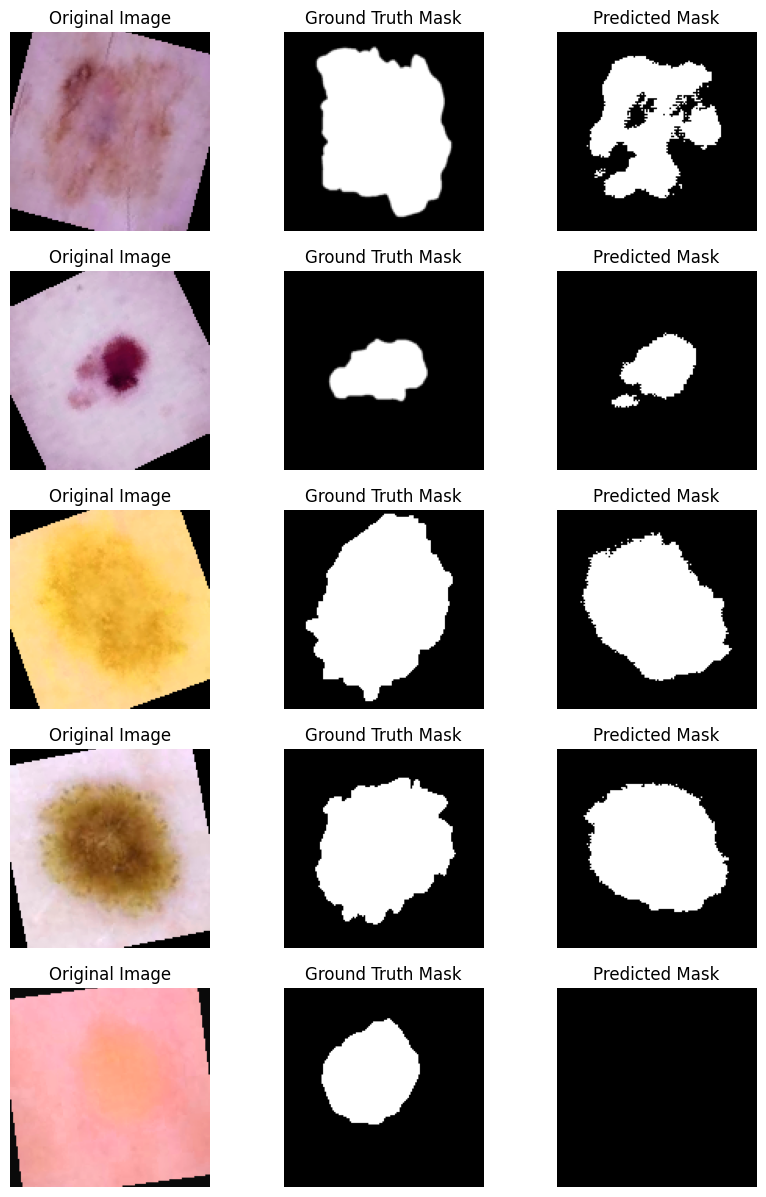

In [ ]:
mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)

def denormalize(img):
    img = img * std + mean
    img = img.clamp(0, 1)
    return img

def visualize_predictions(model, test_loader, num_samples=5):
    model.eval()
    images, masks = next(iter(test_loader))
    images, masks = images[:num_samples].to(device), masks[:num_samples].to(device)

    with torch.no_grad():
        outputs = model(images)
        outputs = (outputs > 0.5).float()

    fig, axes = plt.subplots(num_samples, 3, figsize=(10, num_samples * 3))

    for i in range(num_samples):
        img = images[i].cpu().unsqueeze(0)
        img = denormalize(img).squeeze(0).permute(1, 2, 0).numpy()

        mask = masks[i].cpu().squeeze().numpy()
        pred = outputs[i].cpu().squeeze().numpy()

        axes[i, 0].imshow(img)
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(mask, cmap="gray")
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(pred, cmap="gray")
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis("off")

    plt.show()

visualize_predictions(model, test_loader)
